<a href="https://colab.research.google.com/github/pedrosena138/pt-bert-text-classification/blob/main/BERT_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install datasets transformers evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import tensorflow as tf
from tensorflow import keras
from transformers.keras_callbacks import KerasMetricCallback

from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, BertTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
from evaluate import load

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [11]:
BATCH_SIZE = 16
NUM_EPOCHS = 15

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

MODELS = {
    "pt_br-base": "neuralmind/bert-base-portuguese-cased",
    "pt_br-large": "neuralmind/bert-large-portuguese-cased",
    "multi": "bert-base-multilingual-cased"
}

In [12]:
df = load_dataset("pmfsl/course-feedback-pt_br")
df

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 139
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 251
    })
})

In [13]:
train_neg, train_pos = np.bincount(df['train']['label'])
test_neg, test_pos = np.bincount(df['test']['label'])
val_neg, val_pos = np.bincount(df['validation']['label'])

neg = train_neg + test_neg + val_neg
pos = train_pos + test_pos + val_pos

total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('\nExamples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))

Weight for class 0: 4.43
Weight for class 1: 0.56

Examples:
    Total: 1390
    Positive: 1233 (88.71% of total)
    Negative: 157 (11.29% of total)



In [14]:
max_length = len(df['train']['label'])
model_name = MODELS['pt_br-base']
tokenizer = BertTokenizer.from_pretrained(model_name, model_max_length=max_length)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [15]:
pre_tokenizer_columns = set(df["train"].features)
encoded_df = df.map(preprocess_function, batched=True)
tokenizer_columns = list(set(encoded_df["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['attention_mask', 'input_ids', 'token_type_ids']


In [16]:
def plot_confusion_matrix(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Positives: ', np.sum(cm[1]))

def plot_metrics(history, metrics, title):
    plt.title(title, fontsize=16)
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[n])
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

In [17]:
id2label = {0: "Negative", 1: "Positive"}
label2id = {val: key for key, val in id2label.items()}

batches_per_epoch = len(encoded_df["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

# optimizer = keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

from_pt = True if model_name == MODELS["pt_br-large"] else False

model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                                             num_labels=2,
                                                             id2label=id2label, 
                                                             label2id=label2id,
                                                             from_pt=from_pt)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy())

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# balanced_model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
#                                                              num_labels=2,
#                                                              id2label=id2label, 
#                                                              label2id=label2id,
#                                                              from_pt=from_pt)

# balanced_model.compile(
#         optimizer=optimizer,
#         loss=keras.losses.BinaryCrossentropy())

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_set = model.prepare_tf_dataset(
    encoded_df["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    encoded_df["validation"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    encoded_df["test"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [20]:
class Metric:
    def __init__(self, name, balanced=False):
        self.metric_name = name
        self.func = load(self.metric_name)
        self.balanced = balanced

    def callback(self):
        return KerasMetricCallback(metric_fn=self.compute, eval_dataset=tf_validation_set)
        
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions

        if self.balanced:
            predictions = np.argmax(predictions, axis=1)
        else:   
            predictions = predictions[:, 0]

        compute_func = self.func.compute(predictions=predictions, references=labels)


        if self.metric_name in ('precision', 'recall'):
            compute_func = self.func.compute(predictions=predictions, references=labels, zero_division=0)
          
        return compute_func

callbacks = [
    Metric('precision').callback(),
    Metric('recall').callback(),
    Metric('accuracy').callback(),
    Metric('f1').callback()
]

# balanced_callbacks = [
#     Metric('precision', True).callback(),
#     Metric('recall', True).callback(),
#     Metric('accuracy', True).callback(),
#     Metric('f1', True).callback()
# ]

In [21]:
history = model.fit(tf_train_set, epochs=NUM_EPOCHS, callbacks=callbacks)
model.save_weights('drive/MyDrive/TCC/weights/base-unbalanced-weights.h5')

Epoch 1/15
62/62 [==============================] - 67s 579ms/step - loss: 0.7897 - precision: 0.9600 - recall: 0.5381 - accuracy: 0.5697 - f1: 0.6897
Epoch 2/15
62/62 [==============================] - 31s 503ms/step - loss: 0.4249 - precision: 0.9915 - recall: 0.5202 - accuracy: 0.5697 - f1: 0.6824
Epoch 3/15
62/62 [==============================] - 30s 480ms/step - loss: 0.2532 - precision: 0.9459 - recall: 0.9417 - accuracy: 0.9004 - f1: 0.9438
Epoch 4/15
62/62 [==============================] - 30s 484ms/step - loss: 0.2170 - precision: 0.9930 - recall: 0.6368 - accuracy: 0.6733 - f1: 0.7760
Epoch 5/15
62/62 [==============================] - 29s 464ms/step - loss: 0.1842 - precision: 0.9657 - recall: 0.8834 - accuracy: 0.8685 - f1: 0.9227
Epoch 6/15
62/62 [==============================] - 29s 462ms/step - loss: 0.0889 - precision: 0.9617 - recall: 0.9013 - accuracy: 0.8805 - f1: 0.9306
Epoch 7/15
62/62 [==============================] - 29s 470ms/step - loss: 0.0690 - precision:

In [31]:
history_df = pd.DataFrame(data=history.history)
history_df.to_csv('drive/MyDrive/TCC/histories/base-unbalanced-history.csv')
history_df.mean()

loss         0.155272
precision    0.966058
recall       0.857399
accuracy     0.845418
f1           0.899901
dtype: float64

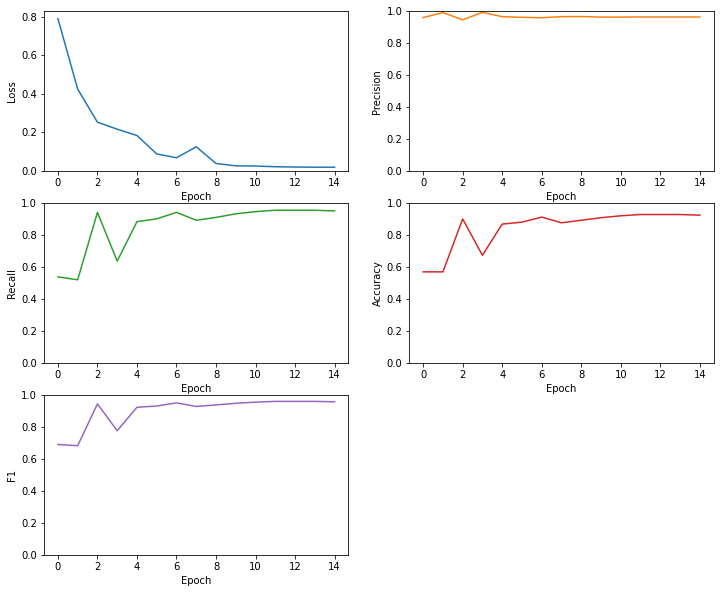

In [33]:
metrics = history_df.columns
plot_metrics(history, metrics, 'Unbalanced training results')

True Negatives:  8
False Positives:  6
False Negatives:  52
True Positives:  73
Total Positives:  125


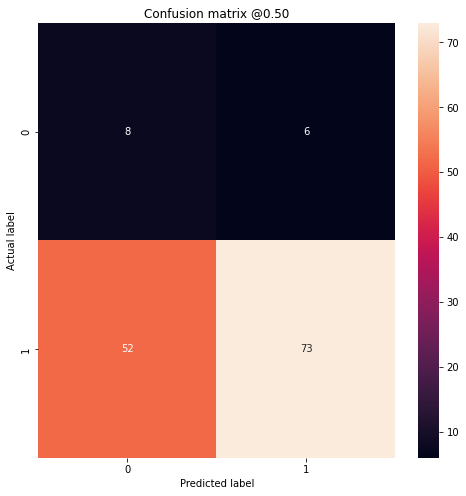

In [29]:
labels = df['test']['label']
encodings = tokenizer(df['test']['text'], return_tensors="np", padding="longest")

outputs = model(encodings).logits
pred = np.argmax(outputs, axis=1)

plot_confusion_matrix(labels, pred)


In [ ]:
# balanced_history = balanced_model.fit(tf_train_set, epochs=NUM_EPOCHS, callbacks=balanced_callbacks, class_weight=class_weight)
# balanced_model.save_weights('drive/MyDrive/TCC/weights/base-balanced-weights.h5')

In [ ]:
# plot_metrics(balanced_history, metrics, 'Balanced training results')